In [1]:
import os
from glob import glob
import IPython.display as ipd
import numpy as np
import matplotlib.pyplot as plt     # for plotting
import cv2 
import soundfile as sf

import librosa
import pandas as pd
from IPython.display import Audio
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow import keras
from keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from collections import Counter

from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [2]:
from numpy.random import seed
seed(1)
tf.random.set_seed(2)

Global Variables

In [3]:
# Data path:
data_path = '../data/'
speakers_path = '../SPEAKERS.TXT'

sample_rate = 32000
off_set = 0
duration = 5.0

# If you decide to use batch sizes:
batch_size = 10000

sample_size = (round((sample_rate*duration)), 1)

#Mel features
hop_length = 512 #the default spacing between frames, try 512?
n_fft = 1024 #number of samples
n_mels = 64

Helper Functions

In [4]:
def extract_id_sex():
    id_sex_array = []
    with open(speakers_path, 'r') as file:
        # Skip the header line
        next(file)
        for line in file:
            # Split the line into columns
            columns = line.split('|')
            # Extract the ID and SEX
            id_value = columns[0].strip()
            sex_value = columns[1].strip()
            # Append ID and SEX to the array
            id_sex_array.append((id_value, sex_value))
    return id_sex_array

# Lets store the speaker gender, it'll only be used once.
speaker_gender = extract_id_sex()

def load_directory():
    # Find all samples in the directory
    files = glob(os.path.join(data_path, '*.flac'))
    # The audio data
    x = []
    # The gender and speaker ID
    y = []

    # Create a dictionary for speaker genders
    speaker_gender_dict = {speaker[0]: speaker[1] for speaker in speaker_gender}

    counter_f = 0
    counter_m = 0
    speakers = []

    if batch_size > len(files):
        error_msg = f'Requested a batch size greater than the number of samples available ({len(files)})'
        raise ValueError(error_msg)

    for file in files:
        if (len(x) == batch_size):
            break
        
        # Collect the speaker IDs, because we are classifying on gender the speakerID does not 
        # matter as a label, but it does help us ensure we have a diverse representation of 
        # speakers for each gender, so we will only take 1 sample per speaker for each gender.
        fileName = file.split('\\')[1]
        speakerId = fileName.split('-')[0]

        # Due to limited number of samples per speaker limit the below code to 14500
        if batch_size < 14500:
            # extract an even number of samples from each speaker ensuring we get a diverse
            # range of speakers 
            num_samples_per_speaker = round(batch_size / 250)
            speaker_count = Counter(speakers)
            if (speaker_count[speakerId] >= num_samples_per_speaker):
                continue
        
        # Use dictionary for faster search performance.
        gender = speaker_gender_dict.get(speakerId)

        if (gender == 'F' and (counter_f < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_f = counter_f + 1

        elif (gender == 'M' and (counter_m < batch_size/2)):
            data, _ = librosa.load(file, sr=sample_rate, offset=off_set, duration=duration)
            if (data.size < (sample_rate*duration)):
                continue
            x.append(data)
            y.append((gender, speakerId))
            speakers.append(speakerId)
            counter_m = counter_m + 1
    x = [get_mels(x_data, sample_rate, hop_length, n_fft, n_mels).T  for x_data in x]
    return np.array(x), np.array(y)

In [5]:
#Helper Functions


def get_mels(x, sample_rate, hop_length=512, n_fft=1024, n_mels=64):
    
    S = librosa.feature.melspectrogram(y =x, sr = sample_rate, hop_length=hop_length,n_fft = n_fft, n_mels=n_mels)
    S_db_mel = librosa.power_to_db(S, ref=np.max)
    return S_db_mel


# Convert iterable into batches of size n
#   iterable: original list of data to be batched
#   n: batch size 

#   yields:   a list of batches with each batch of size n
def batch(iterable, n=1):
    l = len(iterable)
    for ndx in range(0, l, n):
        yield iterable[ndx:min(ndx + n, l)]

# Get y label and a unique ID for each file and load the file into a tuple
#   file: directory to the file

#   returns:   a tuple containing the audio file, speaker ID and a unique ID for the file name
def get_metadata(file):
    basename = os.path.basename(file)
    data, samp_rate = librosa.load(file, sr=sample_rate)
    speakerId = basename.split('-')[0]
    uniqueId = basename.split('.')[0]
    return (data, uniqueId), speakerId



Load Data

In [6]:
x_data, y = load_directory()
# Information on the extracted audio data:
print(f'x data, first sample: {x_data[0]}')
print(f'shape x data: {x_data.shape}')

y_data = np.array([row[0] for row in y])
speakerIds = [row[1] for row in y]
print(f'shape y data: {y_data.shape}')

m_rows = y[y[:, 0] == 'M']
f_rows = y[y[:, 0] == 'F']
print()
print(f'Male Speakers: {len(np.unique(m_rows[:, 1]))}')
print(f'Female Speakers: {len(np.unique(f_rows[:, 1]))}')

x data, first sample: [[-27.368961 -29.47931  -36.750004 ... -75.74742  -75.96059  -76.09476 ]
 [-22.879776 -30.233055 -49.52315  ... -80.       -80.       -80.      ]
 [-21.997183 -28.55328  -47.38311  ... -80.       -80.       -80.      ]
 ...
 [-26.280758 -35.079685 -44.866646 ... -80.       -80.       -80.      ]
 [-17.730782 -24.628962 -51.294506 ... -80.       -80.       -80.      ]
 [-16.015625 -21.281998 -37.17293  ... -80.       -80.       -80.      ]]
shape x data: (10000, 313, 64)
shape y data: (10000,)

Male Speakers: 126
Female Speakers: 125


In [7]:
x_train, x_remain, y_train, y_remain = train_test_split(x_data, y_data, 
                                                        test_size=0.6, 
                                                        random_state=42, 
                                                        shuffle=True,
                                                        stratify=y_data)





x_val, x_test, y_val, y_test = train_test_split(x_remain, y_remain, 
                                                test_size=0.5, 
                                                random_state=42, 
                                                shuffle=True,
                                                stratify=y_remain)

In [9]:
from sklearn.preprocessing import LabelEncoder
# Convert 'M' (1) and 'F' (0) to numbers. 
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.transform(y_val)
y_test_encoded = label_encoder.transform(y_test)
print(y_train[0])
print(y_train_encoded[0])
print(y_train[90])
print(y_train_encoded[90])

M
1
M
1


In [10]:
# X = np.array((X-np.min(X))/(np.max(X)-np.min(X)))
# X = X/np.std(X)
# y = np.array(y)

In [11]:
input_shape=(313, n_mels)
model = keras.Sequential()
model.add(LSTM(60,return_sequences=True, input_shape=input_shape, name='LSTM_1'))
model.add(LSTM(45,return_sequences=True, name='LSTM_2'))
model.add(LSTM(30,return_sequences=True, name='LSTM_3'))
model.add(LSTM(30, name='LSTM_4'))
#model.add(Dense(32, activation='relu'))
#model.add(layers.Dropout(0.2))
#model.add(Dense(16, activation='relu'))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTM_1 (LSTM)               (None, 313, 60)           30000     
                                                                 
 LSTM_2 (LSTM)               (None, 313, 45)           19080     
                                                                 
 LSTM_3 (LSTM)               (None, 313, 30)           9120      
                                                                 
 LSTM_4 (LSTM)               (None, 30)                7320      
                                                                 
 dense (Dense)               (None, 1)                 31        
                                                                 
Total params: 65,551
Trainable params: 65,551
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.compile(optimizer='adam',loss='BinaryCrossentropy',metrics=['acc'])

In [13]:
# two block performs much better than 3 block
import time

start = time.time()


#es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=15)
#mc = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)


history = model.fit(x_train, y_train_encoded, epochs=75, batch_size=100, 
                    validation_data=(x_val, y_val_encoded), shuffle=False, verbose=True)
# fit model
end = time.time() 

model_training = end - start

Epoch 1/75
40/40 [==============================] - 49s 1s/step - loss: 0.6066 - acc: 0.6610 - val_loss: 0.5269 - val_acc: 0.7417
Epoch 2/75
40/40 [==============================] - 45s 1s/step - loss: 0.4301 - acc: 0.8167 - val_loss: 0.3775 - val_acc: 0.8537
Epoch 3/75
40/40 [==============================] - 54s 1s/step - loss: 0.3760 - acc: 0.8490 - val_loss: 0.3265 - val_acc: 0.8760
Epoch 4/75
40/40 [==============================] - 52s 1s/step - loss: 0.3413 - acc: 0.8695 - val_loss: 0.3073 - val_acc: 0.8853
Epoch 5/75
40/40 [==============================] - 53s 1s/step - loss: 0.3561 - acc: 0.8590 - val_loss: 0.3183 - val_acc: 0.8873
Epoch 6/75
40/40 [==============================] - 52s 1s/step - loss: 0.3266 - acc: 0.8775 - val_loss: 0.2906 - val_acc: 0.8970
Epoch 7/75
40/40 [==============================] - 57s 1s/step - loss: 0.3126 - acc: 0.8838 - val_loss: 0.2964 - val_acc: 0.8930
Epoch 8/75
40/40 [==============================] - 56s 1s/step - loss: 0.3050 - acc: 0.88

In [ ]:
#model performance tanks around 75 epochs

In [14]:
print(model_training)
print(model_training/60)

5186.68630027771
86.44477167129517


In [15]:
# import pickle
# pickle.dump(history, open('../out/LSTM_Stacked_history_speaker.pkl', 'wb'))
# pickle.dump(model, open('../out/LSTM_Stacked_Model_speaker.pkl', 'wb'))

In [16]:
# model = pickle.load(open('../out/LSTM_Stacked_Model_speaker.pkl', 'rb'))
# with open('../out/LSTM_Stacked_history_speaker.pkl', "rb") as file_pi:
#     history = pickle.load(file_pi)

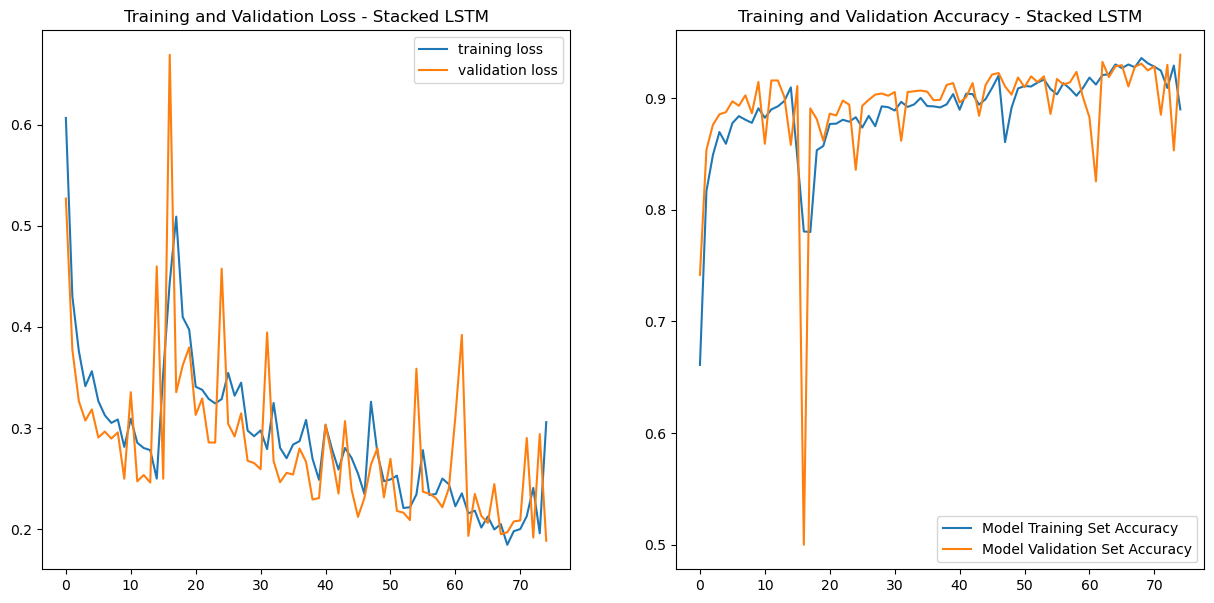

In [17]:
fig = plt.figure(figsize=[15, 7])
ax = fig.add_subplot(1, 2, 1)
ax.plot(history.history['loss'], label='training loss')
ax.plot(history.history['val_loss'], label='validation loss')
ax.set_title('Training and Validation Loss - Stacked LSTM')
ax.legend()
ax = fig.add_subplot(1, 2, 2)
ax.plot(history.history['acc'], label='Model Training Set Accuracy')
ax.plot(history.history['val_acc'], label='Model Validation Set Accuracy')
ax.set_title('Training and Validation Accuracy - Stacked LSTM')
ax.legend()
plt.savefig('../out/Stacked_LSTM_model_loss_overtrained.png')

In [19]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, accuracy_score


pred_lab = model.predict(x_train);
train_indexes = np.round(pred_lab)

pred_lab = model.predict(x_val);
val_indexes = np.round(pred_lab)

start = time.time()

pred_lab = model.predict(x_test);
test_indexes = np.round(pred_lab)

f1_train = f1_score(y_train_encoded, train_indexes)
f1_val = f1_score(y_val_encoded, val_indexes)
f1_test = f1_score(y_test_encoded, test_indexes)

acc_train = accuracy_score(y_train_encoded, train_indexes)
acc_val = accuracy_score(y_val_encoded, val_indexes)
acc_test = accuracy_score(y_test_encoded, test_indexes)

end = time.time()

model_inference = end - start 
print(model_inference)

11.190170049667358


In [24]:
acc_test

0.939

In [22]:
train_indexes_cat = np.where(train_indexes==0, 'F', 'M')
y_train_cat = np.where(y_train==0, 'F', 'M')
test_indexes_cat = np.where(test_indexes==0, 'F', 'M')
y_test_cat = np.where(y_test==0, 'F', 'M')
val_indexes_cat = np.where(val_indexes==0, 'F', 'M')
y_val_cat = np.where(y_val==0, 'F', 'M') 

C:\Users\mpato\AppData\Local\Temp\ipykernel_31832\1552800718.py:2: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_train_cat = np.where(y_train==0, 'F', 'M')
C:\Users\mpato\AppData\Local\Temp\ipykernel_31832\1552800718.py:4: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_test_cat = np.where(y_test==0, 'F', 'M')
C:\Users\mpato\AppData\Local\Temp\ipykernel_31832\1552800718.py:6: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  y_val_cat = np.where(y_val==0, 'F', 'M')


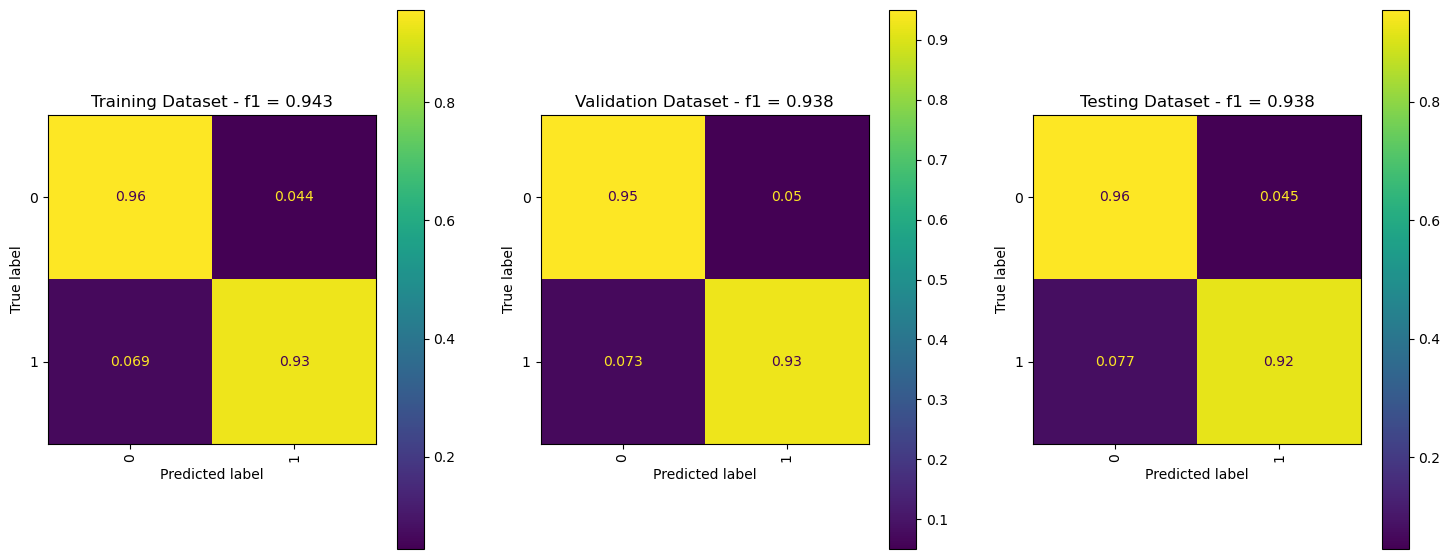

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score
fig = plt.figure(figsize=[18, 7])


ax = fig.add_subplot(1, 3, 1)
ax.set_title(f"Training Dataset - f1 = {round(f1_train, 3)}")
cm = confusion_matrix(y_train, train_indexes_cat, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 2)
ax.set_title(f"Validation Dataset - f1 = {round(f1_val, 3)}")
cm = confusion_matrix(y_val, val_indexes_cat, normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax, xticks_rotation = 'vertical')

ax = fig.add_subplot(1, 3, 3)
ax.set_title(f"Testing Dataset - f1 = {round(f1_test,3)}")
cm = confusion_matrix(y_test, test_indexes_cat, labels = np.array(['F', 'M']), normalize='true')
c = ConfusionMatrixDisplay(cm)
c.plot(ax = ax,  xticks_rotation = 'vertical')

plt.savefig('../out/Stacked_LSTM_Confusion_Matrix.jpg')

c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
c:\Users\mpato\Anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


ValueError: 'c' argument must be a color, a sequence of colors, or a sequence of numbers, not ['M' 'M' 'M' ... 'M' 'M' 'F']

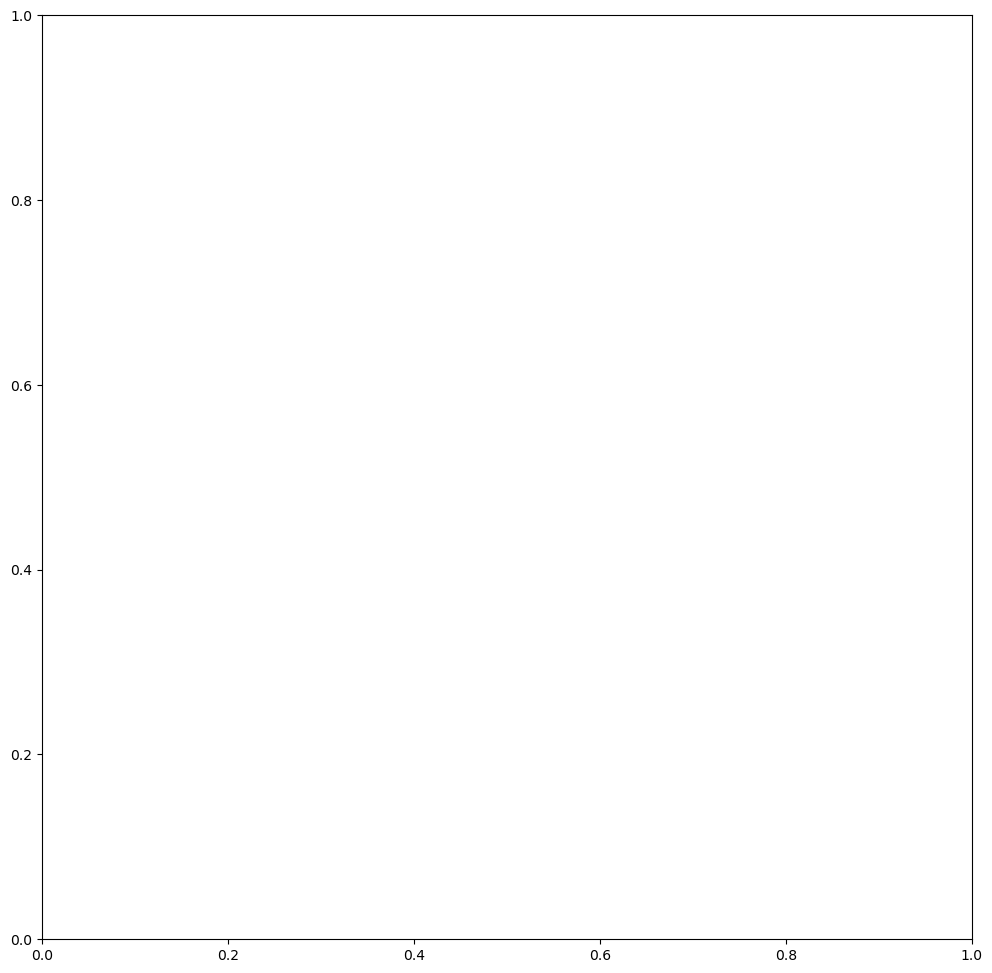

In [21]:
from sklearn.manifold import TSNE

test_embeddings = model.predict(x_test)
tsne_embeddings = TSNE(random_state=4).fit_transform(test_embeddings)
fig = plt.figure(figsize=[12, 12])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = y_test_encoded.flatten(), label = y_test);
plt.legend(['M', 'F'])
plt.savefig('../out/Stacked_LSTM_clusters.jpg')

In [ ]:
import pickle
pickle.dump(history, open('../out/LSTM_Stacked_history_speaker.pkl', 'wb'))
pickle.dump(model, open('../out/LSTM_Stacked_Model_speaker.pkl', 'wb'))

In [ ]:
model = pickle.load(open('../out/LSTM_Stacked_Model_speaker.pkl', 'rb'))
with open('../out/LSTM_Stacked_history_speaker.pkl', "rb") as file_pi:
    history = pickle.load(file_pi)